# Workshop 2: Is it Melting?

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 1.3. Wednesday, Sep 18, 2024.*

In this notebook you will fit a model to a time series of height observations of a point on a glacier, to assess whether it is melting. 

**Learning objectives:**
- apply least-squares (LS) and best linear unbiased (BLU) estimation
- evaluate the precision of the estimated parameters
- discuss the differences between least-squares and best linear unbiased estimation

You have 12 monthly measurements of the height of a point on a glacier. The measurements are obtained from a satellite laser altimeter. The observations are given in the code below.

We will fit a model assuming a linear trend (constant velocity) to account for the melting, plus an annual signal due to the seasonal impact on ice. Formulating a generalized form of this model is part of your task below. Note, however, that the periodic signal can be implemented in many ways. For this assignment you can assume that the periodic term is implemented as follows:

$$
\cos(2 \pi t / 12 + \phi)
$$

where $\phi$ is the phase angle, which we will assume is 0 for this workshop and will leave out of the model formulation in order to keep our model linear (i.e., leave the $\phi$ out of the A-matrix).

The precision (1 $\sigma$) of the first six observations is 0.7 meter, the last six observations have a precision of 2 meter due to a change in the settings of the instrument. All observations are mutually independent.

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution (note)}$

One goal of the assignment was to formulate the model yourself (via the A-matrix). The complete form can also be described using the following analytic expression:

$$
y = x_1 + x_2 t + x_3cos(2 \pi t / 12 + \phi)
$$

Although it may initially seem that the periodic term leaves out the amplitude, you should recognize that the amplitude is in fact implicitly included in the model due to the way $x_3$ is included in the A matrix (i.e., as a linear parameter with the cosine term).

It is important to confirm that your own A-matrix (found during the session) includes all three terms as illustrated above.

Note also that this formulation was part of the reading in the textbook in the exercise page of the Least Squares chapter (3.2). <a href="https://mude.citg.tudelft.nl/2024/book/observation_theory/02_LeastSquares_NB.html" target="_blank">Here is a link</a>.



</p>
</div>

In [11]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# this will print all float arrays with 3 decimal places
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})



## Part 1: Observation model

First we will construct the observation model, based on the following information that is provided: times of observations, observed heights and number of observations. 

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 1.1}:$

Complete the definition of the observation time array <code>times</code> and define the other variables such that the print statements correctly describe the design matrix <code>A</code>.

<em>Use <code>times=0</code> as the first point.</em>
</p>
</div>

In [2]:
y = [59.82, 57.20, 59.09, 59.49, 59.68, 59.34, 60.95, 59.34, 55.38, 54.33, 48.71, 48.47]

# times = YOUR_CODE_HERE
# number_of_observations = YOUR_CODE_HERE
# number_of_parameters = YOUR_CODE_HERE
# print(f'Dimensions of the design matrix A:')
# print(f'  {YOUR_CODE_HERE} rows')
# print(f'  {YOUR_CODE_HERE} columns')

# SOLUTION:
times = np.arange(12)
number_of_observations = len(times)
number_of_parameters = 3

# SOLUTION:
print(f'Dimensions of the design matrix A:')
print(f'  {number_of_observations:3d} rows')
print(f'  {number_of_parameters:3d} columns')

Dimensions of the design matrix A:
   12 rows
    3 columns


Next, we need to assemble the design matrix in Python. Rather than enter each value manually, we have a few tricks to make this easier. Here is an example Python cell that illustrates how one-dimensional arrays (i.e., columns or rows) can be assembled into a matrix in two ways:
1. As diagonal elements, and 
2. As parallel elements (columns, in this case)

Note also the use of `np.ones()` to quickly make a row or column of any size with the same values in each element.

In [3]:
column_1 = np.array([33333, 0, 0])
column_2 = 99999*np.ones(3)

example_1 = np.diagflat([column_1, column_2])
example_2 = np.column_stack((column_1, column_2))

print(example_1, '\n\n', example_2)


[[33333.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 99999.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 99999.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 99999.000]] 

 [[33333.000 99999.000]
 [0.000 99999.000]
 [0.000 99999.000]]


<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>See documentation on <a href="https://numpy.org/doc/stable/reference/generated/numpy.diagflat.html#numpy.diagflat" target="_blank">np.diagflat</a> and <a href="https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html" target="_blank">np.column_stack</a> if you would like to understand more about these Numpy methods.</p></div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 1.2}:$

Complete the $\mathrm{A}$-matrix (design matrix) and covariance matrix $\Sigma_Y$ (stochastic model) as a linear trend with an annual signal. The <code>assert</code> statement is used to confirm that the dimensions of your design matrix are correct (an error will occur if not).
</p>
</div>

In [4]:
# A = YOUR_CODE_HERE
# Sigma_Y = YOUR_CODE_HERE

# SOLUTION: 
A = np.column_stack((np.ones(number_of_observations),
                     times,
                     np.cos(2*np.pi*times/12)))
diag_1 = 0.7**2 * np.ones((1,6))
diag_2 = 2**2 * np.ones((1,6))
Sigma_Y = np.diagflat([diag_1,
                       diag_2])

assert A.shape == (number_of_observations, number_of_parameters)

## 2. Least-squares and Best linear unbiased (BLU) estimation

The BLU estimator is a *linear* and *unbiased* estimator, which provides the *best* precision, where:

- linear estimation: $\hat{X}$ is a linear function of the observables $Y$,
- unbiased estimation: $\mathbb{E}(\hat{X})=\mathrm{x}$,
- best precision: sum of variances, $\sum_i \sigma_{\hat{x}_i}^2$, is minimized.

The solution $\hat{X}$ is obtained as:
$$
\hat{X} = \left(\mathrm{A}^T\Sigma_Y^{-1} \mathrm{A} \right)^{-1} \mathrm{A}^T\Sigma_Y^{-1}Y
$$
Note that here we are looking at the *estimator*, which is random, since it is expressed as a function of the observable vector $Y$. Once we have a realization $y$ of $Y$, the estimate $\hat{\mathrm{x}}$ can be computed.

It can be shown that the covariance matrix of $\hat{X}$ is given by:
$$
\Sigma_{\hat{X}} = \left(\mathrm{A}^T\Sigma_Y^{-1} \mathrm{A} \right)^{-1}
$$

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 2.1}$

Apply least-squares, and best linear unbiased estimation to estimate $\mathrm{x}$. The code cell below outlines how you should compute the inverse of $\Sigma_Y$. Compute the least squares estimates then the best linear unbiased estimate.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>Remember that the <code>@</code> operator (matmul operator) can be used to easily carry out matrix multiplication for Numpy arrays. The transpose method of an array, <code>my_array.T</code>, is also useful.</p></div>

In [5]:
inv_Sigma_Y = np.linalg.inv(Sigma_Y)

# xhat_LS = YOUR_CODE_HERE
# xhat_BLU = YOUR_CODE_HERE

# SOLUTION: 
xhat_LS = np.linalg.inv(A.T @ A) @ A.T @ y
xhat_BLU = np.linalg.inv(A.T @ inv_Sigma_Y @ A) @ A.T @ inv_Sigma_Y @ y

print('LS estimates in [m], [m/month], [m], resp.:\t', xhat_LS)
print('BLU estimates in [m], [m/month], [m], resp.:\t', xhat_BLU)

LS estimates in [m], [m/month], [m], resp.:	 [62.569 -1.046 -3.717]
BLU estimates in [m], [m/month], [m], resp.:	 [62.318 -1.043 -3.235]


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.2:</b>   
The covariance matrix of least-squares can be obtained as well by applying the covariance propagation law.
Calculate the covariance matrix and vector with standard deviations of both the least-squares and BLU estimates. What is the precision of the estimated parameters? The diagonal of a matrix can be extracted with <a href="https://numpy.org/doc/stable/reference/generated/numpy.diagonal.html#numpy.diagonal" target="_blank">np.diagonal</a>.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p><em>Hint: define an intermediate variable first to collect some of the repetitive matrix terms.</em></p></div>

In [6]:
# LT = YOUR_CODE_HERE
# Sigma_xhat_LS = LT YOUR_CODE_HERE
# std_xhat_LS = YOUR_CODE_HERE

# SOLUTION: 
LT = np.linalg.inv(A.T @ A) @ A.T
Sigma_xhat_LS = LT @ Sigma_Y @ LT.T
std_xhat_LS = np.sqrt(np.diag(Sigma_xhat_LS))


# Sigma_xhat_BLU = YOUR_CODE_HERE
# std_xhat_BLU = YOUR_CODE_HERE

# SOLUTION: 
Sigma_xhat_BLU = np.linalg.inv(A.T @ inv_Sigma_Y @ A)
std_xhat_BLU = np.sqrt(np.diagonal(Sigma_xhat_BLU))

print(f'Precision of LS  estimates in [m], [m/month], [m], resp.:', std_xhat_LS)
print(f'Precision of BLU estimates in [m], [m/month], [m], resp.:', std_xhat_BLU)

Precision of LS  estimates in [m], [m/month], [m], resp.: [0.602 0.138 0.673]
Precision of BLU estimates in [m], [m/month], [m], resp.: [0.545 0.137 0.498]


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.3:</b>   
We are mostly interested in the melting rate. Discuss the estimated melting rate with respect to its precision.
</p>
</div>

_Write your answer here._

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 
The melting rate is approximately -1.03 m/month (estimated with BLU), and its precision is around 0.14 m/month, so the estimated signal is large compared to the uncertainty (<em>signal-to-noise ratio</em> is about 1.03/0.14 = 7.5).
</p>
</div>

## 3. Residuals and plot with observations and fitted models.

Run the code below (no changes needed) to calculate the weighted squared norm of residuals with both estimation methods, and create plots of the observations and fitted models. 

Weighted squared norm of residuals with LS  estimation: 10.438
Weighted squared norm of residuals with BLU estimation: 8.147


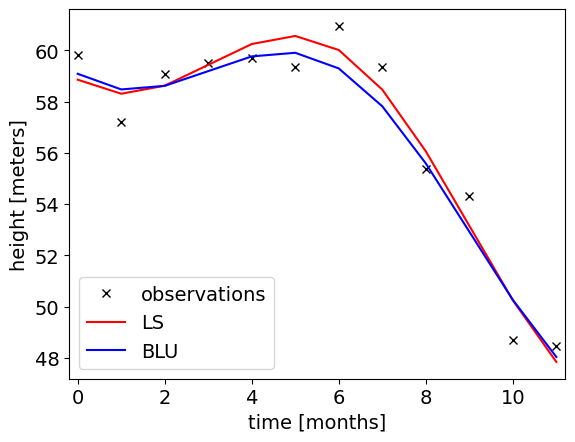

In [7]:
eTe_LS = (y - A @ xhat_LS).T @ (y - A @ xhat_LS)
eTe_BLU = (y - A @ xhat_BLU).T @ inv_Sigma_Y @ (y - A @ xhat_BLU)

print(f'Weighted squared norm of residuals with LS  estimation: {eTe_LS:.3f}')
print(f'Weighted squared norm of residuals with BLU estimation: {eTe_BLU:.3f}')

plt.figure()
plt.rc('font', size=14)
plt.plot(times, y, 'kx', label='observations')
plt.plot(times, A @ xhat_LS, color='r', label='LS')
plt.plot(times, A @ xhat_BLU, color='b', label='BLU')
plt.xlim(-0.2, (number_of_observations - 1) + 0.2)
plt.xlabel('time [months]')
plt.ylabel('height [meters]')
plt.legend(loc='best');

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1:</b>   
<ul>
    <li>Explain the difference between the fitted models.</li>
    <li>Can we see from this figure which model fits better (without information about the stochastic model)?</li>
</ul>
</p>
</div>

_Write your answer here._

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p> 
<ul>
    <li>With LS we give equal weight to all observations, while with BLU the first six observations get larger weight and therefore the fitted line is closer to those observations such that the corresponding residuals are smaller.</li>
    <li>By only looking at figure, we cannot conclude which model fits better, since it does not show that some observations are more precise than others. Therefore we often add error bars.</li>
</ul>

</p>
</div>

   

## 4. Confidence bounds
In the code below you need to calculate the confidence bounds, e.g., ```CI_yhat_BLU``` is a vector with the values $k\cdot\sigma_{\hat{y}_i}$ for BLUE. This will then be used to plot the confidence intervals:
$$
\hat{y}_i \pm k\cdot\sigma_{\hat{y}_i}
$$

Recall that $k$ can be calculated from $P(Z < k) = 1-\frac{1}{2}\alpha$. 

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 4.1}$

Complete the code below to calculate the 98% confidence intervals of both the observations $y$ <b>and</b> the adjusted observations $\hat{y}$ (model values for both LS and BLU).
    
Use <code>norm.ppf</code> to compute $k_{98}$. Also try different percentages.
</p>
</div>

In [8]:
# yhat_LS = YOUR_CODE_HERE
# Sigma_Yhat_LS = YOUR_CODE_HERE
# yhat_BLU = YOUR_CODE_HERE
# Sigma_Yhat_BLU = YOUR_CODE_HERE

# SOLUTION:
yhat_LS = A @ xhat_LS
Sigma_Yhat_LS = A @ Sigma_xhat_LS @ A.T
yhat_BLU = A @ xhat_BLU
Sigma_Yhat_BLU = A @ Sigma_xhat_BLU @ A.T


# alpha = YOUR_CODE_HERE
# k98 = YOUR_CODE_HERE

# SOLUTION: 
alpha = 0.02
k98 = norm.ppf(1 - 0.5*alpha)

# CI_y = YOUR_CODE_HERE
# CI_yhat_LS = YOUR_CODE_HERE
# CI_yhat_BLU = YOUR_CODE_HERE

# SOLUTION: 
CI_y = k98 * np.sqrt(np.diagonal(Sigma_Y))
CI_yhat_LS = k98 * np.sqrt(np.diagonal(Sigma_Yhat_LS))
CI_yhat_BLU = k98 * np.sqrt(np.diagonal(Sigma_Yhat_BLU))

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p><b>Tip:</b> don't forget to include a factor 0.5 (or 2) in your calculation of <code>k98</code> when using the inverse CDF <code>norm.ppf</code>.</p></div>

You can directly run the code below to create the plots.

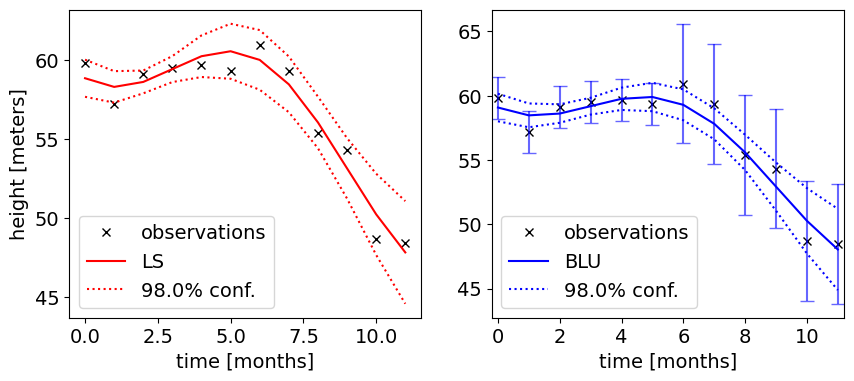

In [9]:
plt.figure(figsize = (10,4))
plt.rc('font', size=14)
plt.subplot(121)
plt.plot(times, y, 'kx', label='observations')
plt.plot(times, yhat_LS, color='r', label='LS')
plt.plot(times, yhat_LS + CI_yhat_LS, 'r:', label=f'{100*(1-alpha):.1f}% conf.')
plt.plot(times, yhat_LS - CI_yhat_LS, 'r:')
plt.xlabel('time [months]')
plt.ylabel('height [meters]')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(times, y, 'kx', label='observations')
plt.errorbar(times, y, yerr = CI_y, fmt='', capsize=5, linestyle='', color='blue', alpha=0.6)
plt.plot(times, yhat_BLU, color='b', label='BLU')
plt.plot(times, yhat_BLU + CI_yhat_BLU, 'b:', label=f'{100*(1-alpha):.1f}% conf.')
plt.plot(times, yhat_BLU - CI_yhat_BLU, 'b:')
plt.xlim(-0.2, (number_of_observations - 1) + 0.2)
plt.xlabel('time [months]')
plt.legend(loc='best');

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.2:</b> 
Discuss the shape of the confidence bounds. Do you think the model (linear trend + annual signal) is a good choice?
</p>
</div>

_Write your answer here._

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

The LS method does not take into account the precision of the observations; this is why there are no error bars plotted on the left figure.

By including the precision of the observations (the error bars in the right figure), as done in the BLU method, you can better assess whether the fit is good.

With BLU: higher precision of first 6 observations, results in tighter confidence intervals as expected. 

Similarly as with a linear trend, you can observe a 'widening' towards to end, the uncertainty in the fitted model is increasing since there is less 'support' from observations on both sides. 

Overall the fitted model seems a good choice: it follows the observations nicely and confidence region seems not too wide compared to the fitted model trend.

Note that for the LS case we use the covariance matrix of the observations; if we had this information to begin with in practice we would <em>not</em> want to use the LS method, as BLU can take it into account in a more complete way. We do it here to compare LS and BLU and to illustrate how the computed model and confidence intervals are improved (more narrow CI) when using BLU.

</p>
</div>



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.3:</b> 
What is the BLU-estimated melting rate and the amplitude of the annual signal and their 98% confidence interval? Hint: extract the estimated values and standard deviations from <code>xhat_BLU</code> and <code>std_xhat_BLU</code>, respectively.
</p>
</div>

In [10]:
# rate =YOUR_CODE_HERE
# CI_rate = YOUR_CODE_HERE

# SOLUTION: 
rate = xhat_BLU[1]
CI_rate = k98 * std_xhat_BLU[1]

# amplitude = YOUR_CODE_HERE
# CI_amplitude = YOUR_CODE_HERE

# SOLUTION: 
amplitude = xhat_BLU[2]
CI_amplitude = k98 * std_xhat_BLU[2]

print(f'The melting rate is {rate:.3f} ± {CI_rate:.3f} m/month (98% confidence level)')
print(f'The amplitude of the annual signal is {amplitude:.3f} ± {CI_amplitude:.3f} m (98% confidence level)')

The melting rate is -1.043 ± 0.318 m/month (98% confidence level)
The amplitude of the annual signal is -3.235 ± 1.158 m (98% confidence level)


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.4:</b> 
Can we conclude the glacier is melting due to climate change?
</p>
</div>

_Write your answer here._

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<ul>
<li>the melting rate is signficant</li>
<li>however, the seasonal signal is quite large compared to the rate and has large uncertainty</li>
<li>need much longer time span to draw firm conclusions</li>
</ul>
</p>
</div>




**End of notebook.**

<div style="margin-top: 50px; padding-top: 20px; border-top: 1px solid #ccc;">
  <div style="display: flex; justify-content: flex-end; gap: 20px; align-items: center;">
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="width:100px; height:auto;" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="width:100px; height:auto;" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="width:88px; height:auto;" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
  </div>
  <div style="font-size: 75%; margin-top: 10px; text-align: right;">
    &copy; Copyright 2024 <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE</a> TU Delft. 
    This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0 License</a>.
  </div>
</div>


<!--tested with WS_2_8_solution.ipynb-->